<a href="https://colab.research.google.com/github/AbdulQadir8/CourtOrderAnalyzer/blob/master/text_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Court Order Document Analyzer

# Court Order Text Analyzer with LangGraph  

In this tutorial, we'll showcase the capabilities of **LangGraph** by building a multi-step court order text analysis pipeline. This pipeline will help transform complex court orders into accessible information through three key stages:

### 1. Text Classification  
We'll categorize the court order into predefined categories such as **Civil**, **Criminal**, **Family Law**, or **Administrative** cases. This step helps in quickly understanding the context of the order.

### 2. Entity Extraction  
We'll identify and extract key legal entities from the court order, including:  
- **Parties involved** (e.g., plaintiff, defendant)  
- **Case numbers**  
- **Dates**  
- **Key legal terms**  

This ensures essential information is highlighted for easy reference.

### 3. Text Summarization  
Finally, we'll generate a concise, plain-language summary of the court order. This will distill the core points, making complex legal language understandable for non-experts.

---

This pipeline demonstrates how **LangGraph** can be used to build a modular, extensible workflow for processing legal documents. By the end of this tutorial, you'll understand how to construct a graph-based application that can be expanded or customized for various legal text analysis tasks, improving accessibility and comprehension.


# Installations

In [1]:
%%capture --no-stderr
%pip install -U langchain_google_genai langgraph load_dotenv

# Import Required Libraries
This cell imports all the necessary modules

In [2]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langgraph.graph.state import CompiledStateGraph
from langchain_google_genai import ChatGoogleGenerativeAI


from dotenv import load_dotenv

# Set Up API Keys

In [3]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [4]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

#Building the Text Processing Pipeline
#Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the ChatGoogleGenerativeAI model.

In [5]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model= "gemini-1.5-flash", api_key=GEMINI_API_KEY)

# Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [6]:
def classification_node(state: State):
  ''' Classify the text into one of the categories: Civil, Criminal, Family Law, Administrative or Other '''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Classify the following text into one of the categories: Civil, Criminal, Family Law, Administrative or Other.\n\nText:{text}\n\nCategory:"
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  classification = llm.invoke([message]).content.strip()
  return {"classification": classification}

def entity_extraction_node(state: State):
  '''Extract all the entities (Parties Involved, Legal Terms,  Legal Procedure, Legal Outcomes and Case Information) from the following text '''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Extract all the entities (Parties Involved, Legal Terms,  Legal Procedure, Legal Outcomes and Case Information) from the following text. Provide the result as a comma-seprated list.\n\nText:{text}\n\nEntities:"
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  entities=llm.invoke([message]).content.strip().split(", ")
  return {"entities": entities}

def summarization_node(state: State):
  ''' Summarize the text in one short sentence'''
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
  )
  message = HumanMessage(content=prompt.format(text=state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary": summary}

# **Create Tools and Build Workflow**


This cell builds the StateGraph workflow.

In [7]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)


# Add edges to the graph
workflow.set_entry_point("classification_node")  # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction","summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

# Visualizing the Workflow
This cell creates a visual representation of our workflow using Mermaid

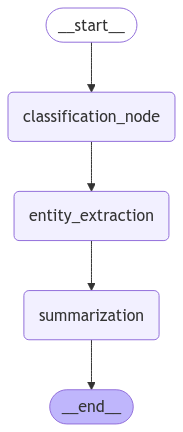

In [8]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

#Testing the Pipeline
This cell runs a sample text through our pipeline and displays the results.

In [9]:
sample_text = """
H C J D A 38.
JUDGMENT SHEET
IN THE LAHORE HIGH COURT MULTAN BENCH,
MULTAN
JUDICIAL DEPARTMENT

MUHAMMAD WAHEED KHAN, J.- Through
the instant appeal, the appellant has challenged conviction and
sentence awarded to him by the learned Addl. Sessions Judge,
Dera Gazi Khan vide judgment dated 25.02.2023 in case FIR
No.709 dated 04.09.2022 registered u/s 9 (c) of the Control of
Narcotic Substances Act, 1997 at Police Station Gaddai, Dera
Gazi Khan, whereby on conclusion of trial, he was convicted
u/s 9 (c) of the Control of Narcotic Substances Act, 1997 and
sentenced to rigorous imprisonment for six years and six
months alongwith fine of Rs.30,000/-, in default thereof, to
further undergo six months simple imprisonment. Benefit of
section 382-B Cr.P.C. was also extended to him.
2. Facts of the case are that on 04.09.2022, when
complainant, Muhammad Tahir Saleem T/SI alongwith
other officials was present at Paigah Chowk, on a tip off,
they chased the appellant who was coming on a
motorcycle and when a cloth bag hanging with the handle
of his motorcycle was opened, three packets of charas (out
of which one packet wrapped in yellow coloured tape
Cr. Appeal No.206 of 2023
Muhammad Adnan v. The State
JUDGMENT
Date of hearing 26.09.2023
Appellant by: Ch. Umar Hayat, Advocate.
Complainant/
State by:
Mr. Muhammad Ali Shahab, Deputy
Prosecutor General.
2
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
weighing 1080 grams, second wrapped in a blue coloured
tape weighing 1070 grams and the third packet wrapped in
blue coloured shopper bag weighing 1020 grams), total
weighing 3170 grams, were recovered and an amount of
Rs.4350/- was also recovered from him. The complainant
prepared three separate sealed parcels of samples and three
others of the remaining case property and took the said six
parcels alongwith motorcycle and cash into possession,
hence, this case.
3. After registration of case, police investigated the matter
and submitted report u/s 173 Cr.P.C. before the learned trial
Court by declaring the appellant as guilty. Learned trial Court
after completing codal formalities, framed charge against the
appellant, which was denied by him, so, the prosecution
evidence was summoned. In order to prove the charge against
the appellant, the prosecution produced as many as six
witnesses. Allah Bachaya ASI, who chalked out FIR appeared
as PW-1, Shehbaz Qalandar 924/HC, Moharrar of Police
Station appeared as PW-2, Muhammad Sadiq SI,
Investigating Officer of the case appeared as PW-3, Allah
Dewaya 930/C witness of recovery appeared as PW-4, Tahir
Saleem T/SI complainant of the case appeared as PW-5 and
Muhammad Qasim 1148/C, who transmitted the complaint to
the Police Station appeared as PW-6. The prosecution after
producing certain documents including report of Punjab
Forensic Science Agency (Ex-PG) closed its evidence. The
appellant was examined u/s 342 Cr.P.C., wherein he denied all
the allegations leveled against him. He did not opt to appear u/s
340(2) Cr.P.C. as his own witness, however, produced certain
documents in his defence.
4. In support of the instant appeal, learned counsel for the
appellant has submitted that the prosecution story is inherently
3
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
flawed, failed to inspire confidence and the impugned judgment
is not only based on surmises and conjectures but material
evidence available on record has been mis-read; In alternate,
learned counsel for the appellant submits that since the
prosecution remained failed to prove the case qua the safe
custody of the parcels containing the case property so the same
cannot be used against the appellant and the maximum he could
be saddled with the responsibility to the extent of sample
parcels containing 54/54 grams and 51 grams (total 159 grams)
of contraband in the light of guidelines given by the august
Supreme Court of Pakistan in case titled as “AMEER ZEB v.
THE STATE” (PLD 2012 Supreme Court 380).
5. Conversely, learned Deputy Prosecutor General while
faithfully supporting the impugned judgment, candidly admitted
that the prosecution could not prove the safe custody of the
parcels containing the case property, so, the appellant can only
be held responsible of quantity of narcotics containing in
sample parcels i.e. 159 grams.
6. We have heard the arguments of learned counsel for the
appellant, learned Law Officer and perused the record with their
assistance. On in depth analysis of record, we have straightway
noticed that as per testimony of Shahbaz Qalandar 924/HC
Moharrar Police Station (PW-2), he handed over the parcels
containing the case property to Tahir Saleem SI (PW-5)
complainant of the case, for depositing the same in Sadar Mall
Khana on 06.09.2022. Regarding this fact, he (PW-2) deposed
in the dock in the following manner;-
“I sent the case property to Malkhana Saddar through
Tahir Saleem SI on 06.09.2022. I.O recorded my statement
in this regard. The parcels remained intact as long as in my
custody.”
But the said Tahir Saleem SI, while appearing before the
learned trial Court as PW-5 did not depose a single word
4
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
regarding receiving the parcel(s) containing case property from
Moharrar Police Station (PW-2) for depositing the same in
Saddar Malkhana. The said portion of testimony of (PW-5) is
reproduced as under;-
“On 05.09.2022, Shahbaz Qalandar Moharrir handed over
to me three sample parcels for onward transmission to the
office of PFSA alongwith road certificate 990/2021, which
I deposited the aforesaid office on 06.09.2022 intact.”
It shows that PW-5 did not depose about receiving of parcels
containing case property for depositing the same in the Saddar
Malkhana in safe custody.
7. A case under the Control of Narcotic Substances Act,
1997 contains two components/limbs i.e. firstly, the prosecution
is bound to establish the safe custody and safe transmission
from the place of recovery of seized drug by the police,
including separation of representative parcel(s) of the seized
drug and its despatch to the testing laboratory and secondly, the
chain of custody of the parcel(s) containing the ‘case property’
is also pivotal, and the prosecution is also supposed to prove its
safe custody as far as the same remained with the police and
then despatched to the trial Court as a ‘case property’ intact,
and any break in the chain of custody or lapse in the control of
possession of the sample(s) containing case property causes
doubt on its safe custody and safe transmission to the Court of
law. In case of “AMEER ZEB v. THE STATE” (PLD 2012
Supreme Court 380), the top Court has observed that the
Control of Narcotic Substances Act, 1997, stipulates
disproportionately long and harsh sentences and, therefore, for
the purpose of safe administration of criminal justice, some
minimum standards of safety are to be laid down so as to strike
a balance between the prosecution and the defence and to
obviate chances of miscarriage of justice on account of
exaggeration by the Investigating Agency. Such minimum
5
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
standards of safety are even otherwise necessary for
safeguarding the Fundamental Rights of the citizens regarding
life and liberty which cannot be left at the mercy of verbal
assertions of police officers, which assertions are not supported
by independent evidence provided by a Chemical Examiner. In
cases of “The State through Regional Director ANF v. Imam
Bakhsh and others” (2018 SCMR 2039), “Ikramullah and
others v. The State” (2015 SCMR 1002) and “Amjad Ali v. The
State” (2012 SCMR 577), the Apex Court had bound down the
prosecution to substantiate the safe transmission of sample(s) of
the recovered substance right from its recovery from the
accused, keeping it safe with the police and then its onward
transmission to the Forensic Laboratory but in case of “ABDUL
GHANI and others v. The STATE and others” (2019 SCMR
608), the top Court went ahead of this by observing that in a
case where the safe custody of the recovered substance or safe
transmission of sample(s) of the recovered substance was not
proved by the prosecution through independent evidence, it
cannot not be concluded that the prosecution had succeeded in
establishing its case against the accused beyond reasonable
doubt. In the above referred case, the top Court had given its
observation in the following manner;-
“There is hardly any occasion for discussing the merits of
the case against the appellants because the record of the
case shows that safe custody of the recovered substance as
well as safe transmission of samples of the recovered
substance to the office of the Chemical Examiner had not
been established by the prosecution in this case. Nisar
Ahmad, S.I./SHO complainant (PW1) had stated before the
trial Court that he had deposited the recovered substance
at the Malkhana of the local Police Station but admittedly
the Moharrir of the said Police Station had not been
produced before the trial Court to depose about safe
custody of the recovered substance."
Underline provided for emphasis.
Meaning thereby that it was incumbent upon the prosecution to
prove the safe custody and transmission of both components/
6
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
limbs of case i.e. sample parcel(s) and the case property. In the
judgment passed by this Court in case of “ABID ALI v. The
STATE” (2022 P.Cr.L.J 1088), the case of the prosecution was
disbelieved as the prosecution remained unable to prove the
safe custody of the second component i.e. safe custody of
parcel(s) containing the case property. In another judgment
rendered by this Court in case of “ABDUL GHAFOOR v. The
STATE and others” (2021 P.Cr. L J 1624), it had been
observed that a portion of 78 grams of recovered narcotic was
segregated for chemical analysis and the rest of 1472 grams
recovered narcotic was secured separately however, prosecution
witnesses could not prove as to who transmitted parcel
containing said 1472 grams and no evidence was presented to
show how such parcel was retrieved and brought to Court to be
exhibited as evidence. The accused was held responsible/guilty
to the extent of narcotic containing sample parcel.
8. So, in the light of above discussion, we believe that the
prosecution remained failed to adduce the evidence qua the safe
custody and safe transmission of the sample(s) containing the
‘case property’ as observed earlier that Tahir Saleem SI (PW-5)
had not deposed in the line of the assertion of Shahbaz
Qalandar 924/HC, Moharrar of Police Station (PW-2), wherein
he claimed that he handed over the parcels containing the case
property to the said Tahir Saleem SI (PW-5), rather he did not
utter a single word about handing over the parcels containing
‘case property’ to him. Meaning thereby that an important link
is missing regarding the safe custody of the ‘case property’ and
we have reached to an irresistible conclusion that the
prosecution remained failed to prove its case to the extent of
parcels containing the ‘case property’. Hence, in all
eventualities the narcotic containing the ‘case property’ cannot
be used against the appellant. So, he cannot be held guilty of
7
Cr. Appeal No.206 of 2023
(Muhammad Adnan v. The State, etc)
the quantity i.e. 3011 grams of charas and as such conviction
and sentence awarded to him by the learned trial Court u/s 9 (c)
of the Act ibid cannot be allowed to stand, rather he would be
convicted and sentenced to the extent of samples consisting of
54/54 grams and 51 grams (total 159 grams), which were
received in the Punjab Forensic Science Agency (PFSA) and
the same were tested as positive through report Ex-PG.
Therefore, the appellant is held responsible for having only to
the extent of three ‘sample parcels’ weighing 156 grams in his
possession. In this view of the matter conviction recorded by
the learned trial Court is converted into conviction of the
appellant from section 9 (c) to section 9 (b) of the Act ibid and
he is sentenced to one year and three months rigorous
imprisonment and fine of Rs.9,000/-, in default whereof, to
further undergo simple imprisonment for three months and
fifteen days while applying the sentencing policy of this Court,
laid down in case of “GHULAM MURTAZA and another v.
THE STATE” (PLD 2009 Lahore 362). Benefit of section 382-
B Cr.P.C. is also extended to the appellant.
9. With the above modification in conviction and sentence
of the appellant, the instant appeal is dismissed.
(SARDAR MUHAMMAD SARFRAZ DOGAR) (MUHAMMAD WAHEED KHAN)
 JUDGE JUDGE
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: Criminal Law

Entities: ['Muhammad Waheed Khan', 'J.', 'Muhammad Adnan', 'The State', 'Ch. Umar Hayat', 'Mr. Muhammad Ali Shahab', 'Addl. Sessions Judge', 'Dera Gazi Khan', 'Muhammad Tahir Saleem', 'Allah Bachaya ASI', 'Shehbaz Qalandar', 'Muhammad Sadiq SI', 'Allah Dewaya', 'Muhammad Qasim', 'Punjab Forensic Science Agency', 'Ameer Zeb', 'The State (PLD 2012 Supreme Court 380)', 'The State through Regional Director ANF', 'Imam Bakhsh', 'Ikramullah', 'Amjad Ali', 'Abdul Ghani', 'Abid Ali', 'Abdul Ghafoor', 'Ghulam Murtaza', 'Control of Narcotic Substances Act', '1997', 'Cr. Appeal No.206 of 2023', 'FIR No.709', 'Section 9 (c)', 'Section 9 (b)', 'Section 382-B Cr.P.C.', 'Section 173 Cr.P.C.', 'Section 342 Cr.P.C.', 'Section 340(2) Cr.P.C.', ' Rigorous imprisonment', 'Simple imprisonment', 'Fine', ' Conviction', 'Appeal', 'Judgment', ' Trial', ' Evidence', 'Prosecution', 'Defence', 'Safe custody', 'Chain of custody', 'Chemical Examiner', ' Miscarriage of justice', ' Sampl

#Conclusion
In this tutorial, we've:

*   Explored LangGraph concepts
*   Built a text processing pipeline
*   Demonstrated LangGraph's use in data processing workflows
*   Visualized the workflow using Mermaid

This example showcases how LangGraph can be used for tasks beyond conversational agents, providing a flexible framework for creating complex, graph-based workflows.